In [1]:
%matplotlib inline
import os 
import sys
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
pd.options.display.max_columns = 999
import statsmodels.formula.api as smf
import scipy.stats as ss 
import math 
from outliers import smirnov_grubbs as grubbs

plt.rcParams['font.family'] = 'Myriad Pro'
sns.set_style('white')

datadir       = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSM/Oct_19'
mrsdir        = '/Users/kanaan/SCR/Dataframes_20150820/REVISION_DF'
clinical_dir  = '/Users/kanaan/SCR/Dataframes_20150820/DF_clinical/'
save_fig_dir  = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python'

measures = ['Puta', 'Caud', 'Thal',
            'SN', 'STN', 'RN',  'GPi' , 'GPe',  
            #'DN','Hipp', 'Accu', 'Amyg', 
            #'STR_cMOT', 'STR_rMOT','AAN_PPN','AAN_VTA',
            'BrainStem', 'BasalGanglia', 'ALL_NUCLEI'
            ]
clinical = ['CLN_BAI','CLN_BAI_clinically_significant',
            'CLN_BAI_severity','CLN_BDI12','CLN_BDI12_clinically_significant',
            'CLN_BDI12_severity','CLN_Birthday','CLN_CAARS_Score_ADHS_Symptoms_Total_Cat_G_T_Score',
            'CLN_DSM4_ADHD_Score','CLN_DSM4_Attention','CLN_DSM4_Hyperactivity',
            'CLN_DSM4_clinically_significant_ADHD','CLN_Diag_ADHD','CLN_Diag_AQ',
            'CLN_Diag_Anxiety','CLN_Diag_Depression','CLN_Diag_OCD','CLN_Ferritin',
            'CLN_MADRS','CLN_MADRS_clinically_significant','CLN_MADRS_severity',
            'CLN_OCIR_Control','CLN_OCIR_Control_clinically_significant','CLN_OCIR_Hoarding',
            'CLN_OCIR_Hoarding_clinically_significant','CLN_OCIR_Mental_Neutralisation',
            'CLN_OCIR_Mental_Neutralisation_clinically_significant','CLN_OCIR_Thoughts',
            'CLN_OCIR_Thoughts_clinically_significant','CLN_OCIR_Tidy','CLN_OCIR_Tidy_clinically_significant',
            'CLN_OCIR_WASH_clinically_significant','CLN_OCIR_Wash',#'CLN_OCIR_total score',
            'CLN_RVTRS',
            'CLN_THC_occasional',
            'CLN_YBOCS_Totalscore_Items_1to10',
            'CLN_YBOCS_Totalscore_Items_1to10_clinically_significant','CLN_YBOCS_compulsions',
            'CLN_YBOCS_compulsions_sig','CLN_YBOCS_obsessions','CLN_YBOCS_obsessions_sig',
            'CLN_YGTSS_Motoric_Score','CLN_YGTSS_Total_Score_incl_Impairment',
            'CLN_YGTSS_Total_Tic_Score','CLN_YGTSS_Vocal_Score','CLN_medication',
            'CLN_puts','CLN_puts_meaning','CLN_qol_scale',
            'CLN_qol_score',]

drop_c = ['WSKT','SC1T','LL5T', 'GSAT'] 
# WSKT,SC1T,LL5T Young Females scanned extra for MRS review. 
# GSAT removed since HSPP female removed 
drop_p = ['AA8P', 'RA9P', 'STDP','NL2P','HSPP', 'DF2P'] 
# AA8P motion outliers via mehalonobis distance for Quality metrics 
# rest – mehalonobis distance for SN,STN,Puta


In [2]:

def get_all_dfs(img, population, study_id, trt=False):
    quant = 'median'
    QSM = pd.read_csv(os.path.join(datadir, '%s_%s_%s_%s.csv'%(img, quant, population, study_id)),index_col = 0)
    QSM['Gender']  = QSM['Gender'].map({' F': 1, ' M': 0})
    
    CLN = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s_a.csv'%(population)), index_col=0)
    CLN.columns = ['CLN_' + str(col) for col in CLN.columns]    

    def get_mrs(vox):
        if trt == False:
            df = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_%s.csv'%(vox, population, study_id)),index_col = 0)
        elif trt == True:
            df = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_trt_%s.csv'%(vox, population, study_id)),index_col = 0)
        df.columns = ['%s_'%vox + str(col) for col in df.columns]
        return df
    df = pd.concat([QSM, get_mrs('STR'), CLN], axis=1, join_axes=[QSM.index])
    df['L_BrainStem']    = (df['L_STN'] + df['L_SN'] +  df['L_RN']) / 3
    df['R_BrainStem']    = (df['R_STN'] + df['R_SN'] +  df['R_RN']) / 3
    df['L_BasalGanglia'] = (df['L_Puta'] + df['L_Caud'] +  df['L_Pall'] +  df['L_Accu']) / 4
    df['R_BasalGanglia'] = (df['R_Puta'] + df['R_Caud'] +  df['R_Pall'] +  df['R_Accu']) / 4
    df['ALL_NUCLEI'] = (df['BrainStem'] + df['BasalGanglia']) / 2
    df['L_ALL_NUCLEI'] = (df['L_BrainStem'] + df['L_BasalGanglia']) / 2
    df['R_ALL_NUCLEI'] = (df['R_BrainStem'] + df['R_BasalGanglia']) / 2
    df['ALL_NUCLEI'] = (df['BrainStem'] + df['BasalGanglia']) / 2
    return df

controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)
controls_b = get_all_dfs('QSM', 'controls', 'b', trt=True)#.drop(drop_c, axis = 0) 
patients_b = get_all_dfs('QSM', 'patients', 'b', trt=True)#.drop(drop_p, axis = 0) 

controls_a['Population'] = 0
patients_a['Population'] = 1
    
controls_b.index = controls_b.index + 'b'
patients_b.index = patients_b.index + 'b'

DF_ALL =pd.concat([controls_a, patients_a], axis=0)

In [3]:
def grubbs_outliers(df, measure, alpha = 0.15):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 

def gESD_outliers(df, measure, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df[measure],maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 

def plot_partial_correlation(data, x, y, regressors = None, color = None, annotate = None, fig_name = None, 
                             dpi = 100, labels = True, jitter = None,fit_reg=True, scatter=1,
                             plot_marg = 1, xlim = None, ylim = None):
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    df = pd.concat([df_reg, data[x], data[y]], axis=1).dropna()
    
    # inititlize grid and plot regression and margins 
    grid = sns.JointGrid(x, y, data=df)#,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
    
    if plot_marg:
        grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, fit_reg=fit_reg, scatter= scatter, color = color, x_partial = df[regressors], y_jitter = jitter)
    if labels:
        grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels(None,None)
        
    ## calculate regression parameters 
    
    formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 3)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    if annotate:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)
    return result

def plot_joint(df,m1,m2, drop = []):
    DF  = pd.DataFrame([df[m1] , df[m2]] ).T.dropna()
    sns.jointplot(x=m1, y=m2, data=DF.drop(drop, axis = 0), kind = 'reg')

In [4]:
def plt_resid(data, x, y, regressors = None, color = None, annotate = None, fig_name = None, 
              dpi = 100, labels = True, jitter = None,fit_reg=True, scatter=1,
              plot_marg = 1, xlim = None, ylim = None):

    def get_resid(df,measure, regressors):
        formula = [ '%s ~ %s'%(measure,regressors[0])  + ' + %s'%regressor for regressor in regressors[1:]][0]#  
        res= smf.ols(formula=formula, data= df).fit().resid
        return res
    
    x_resid = get_resid(data,x, regressorsx)
    y_resid = get_resid(data,y, regressorsx)
    df = pd.concat([x_resid, y_resid], axis=1).dropna()
    df.columns = [x,y]
    
    grid = sns.JointGrid(x, y, data=df,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
    
    if plot_marg:
        grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, fit_reg=fit_reg, scatter= scatter, color = color, y_jitter = jitter)
    if labels:
        grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels(None,None)
    formula = [ '%s ~ %s'%(y,x)][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 3)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    if annotate:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')

    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)


In [5]:
def return_correlation_tables(data, regressors, metabolites, clinical_measures):
    
    print 'Bonferroni threshold =',  0.05/ (len(clinical_measures) * len(metabolites) )
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    
    
    def make_multiple_reg(data, x, y):
        #print np.log((data[y] + 10))
        x_out = gESD_outliers(data, x)
        y_out = gESD_outliers(data, y)
        #print x, x_out 
        #print y, y_out
        df = pd.concat([df_reg, data[x].drop(x_out,axis=0), data[y].drop(y_out,axis=0) ], axis=1)
        #df = df.dropna()
        #df[x] = (df[x] - np.mean(dfx[x]) )/  np.std(dfx[x])
        
        formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
        model   = smf.ols(formula=formula, data= df)
        result = model.fit() 
        p_val  = np.round(result.pvalues[1], 3)
        pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
        
        if p_val < 0.06:
            print x, y, 'P_val=', p_val, 'R =', pcor
        return pcor, p_val
    
    stats_df = pd.DataFrame(index = clinical_measures,  columns=metabolites)   
    
    for clinical in clinical_measures:
        for metabolite in metabolites:
            p_cor, p_val = make_multiple_reg(data,  clinical, metabolite )
            #p_cor, p_val = spearmanr(data[clinical], data[metabolite])
            stats_df.loc['%s'%clinical][metabolite] = np.round(p_cor,3)
            stats_df.loc['%s'%clinical][metabolite] = np.round(p_val,3)
    return stats_df


In [6]:
clinical = ['CLN_RVTRS','CLN_YGTSS_Motoric_Score','CLN_YGTSS_Total_Score_incl_Impairment',
            'CLN_YGTSS_Total_Tic_Score','CLN_YGTSS_Vocal_Score',
            'CLN_puts','CLN_qol_score']

measures = ['Puta', 'Caud', 'Thal',
            'SN', 'STN', 'RN',  'GPi' , 'GPe',  
            #'DN','Hipp', 'Accu', 'Amyg', 
            #'STR_cMOT', 'STR_rMOT','AAN_PPN','AAN_VTA',
            'BrainStem','BasalGanglia', 'ALL_NUCLEI', 
           ]

measures = ['L_' + str(i) for i in measures]    
measures.append('CLN_Ferritin')
res = return_correlation_tables(patients_a, ['Age', 'Gender', 'QI1_MAG'], measures, clinical)
res

Bonferroni threshold = 0.000595238095238
CLN_qol_score L_STN P_val= 0.043 R = -0.457


,L_Puta,L_Caud,L_Thal,L_SN,L_STN,L_RN,L_GPi,L_GPe,L_BrainStem,L_BasalGanglia,L_ALL_NUCLEI,CLN_Ferritin
CLN_RVTRS,0.572,0.061,0.998,0.12,0.982,0.402,0.811,0.228,0.829,0.166,0.51,0.879
CLN_YGTSS_Motoric_Score,0.935,0.478,0.491,0.507,0.634,0.56,0.106,0.541,0.442,0.706,0.474,0.645
CLN_YGTSS_Total_Score_incl_Impairment,0.281,0.469,0.568,0.712,0.502,0.793,0.352,0.81,0.552,0.585,0.519,0.864
CLN_YGTSS_Total_Tic_Score,0.731,0.808,0.336,0.689,0.746,0.631,0.384,0.759,0.591,0.836,0.631,0.934
CLN_YGTSS_Vocal_Score,0.651,0.911,0.338,0.297,0.425,0.268,0.817,0.387,0.184,0.577,0.23,0.678
CLN_puts,0.179,0.157,0.628,0.572,0.607,0.507,0.41,0.089,0.434,0.133,0.259,0.618
CLN_qol_score,0.444,0.551,0.723,0.221,0.043,0.732,0.242,0.532,0.196,0.324,0.182,0.49


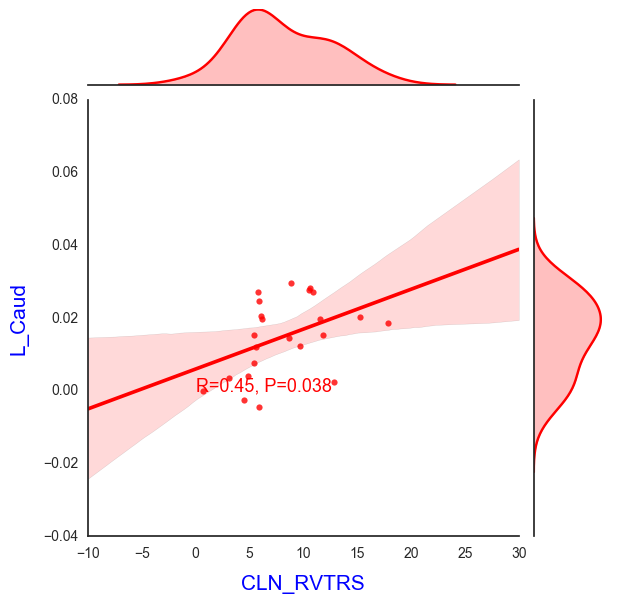

In [161]:
df = patients_a#pd.concat([patients_a, patients_b], axis=0)
x = 'CLN_RVTRS'
y = 'L_Caud'
#plot_joint(df,x,y, drop = [])
plot_partial_correlation(df, x, y, regressors = ['Age','Gender', 'QI1_MAG'], color = 'r', 
                         annotate = (0,0), fig_name = None, 
                         dpi = 100, labels = True, jitter = None,fit_reg=True, scatter=1, plot_marg = 1)

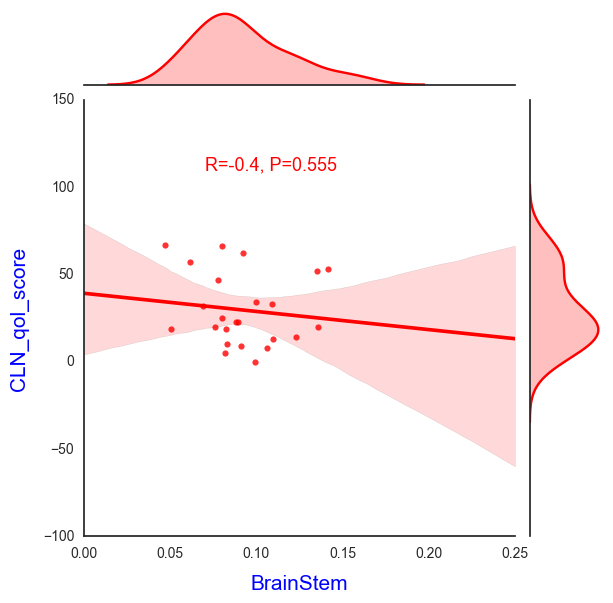

In [60]:
df = patients_a#pd.concat([patients_a, patients_b], axis=0)
x = 'BrainStem'
y = 'CLN_qol_score'
#plot_joint(df,x,y, drop = [])
plot_partial_correlation(df, x, y, regressors = ['Age', 'Gender'], color = 'r', 
                         annotate = (0.07,110), fig_name = None, 
                         dpi = 100, labels = True, jitter = None,fit_reg=True, scatter=1, plot_marg = 1)

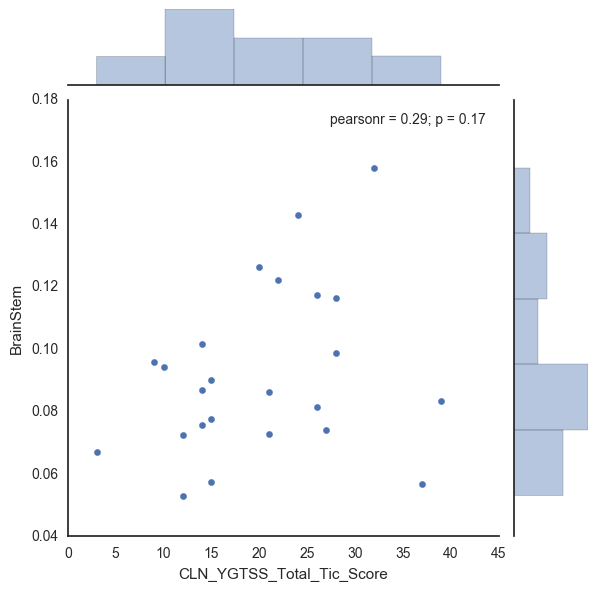

In [61]:
sns.jointplot(df['CLN_YGTSS_Total_Tic_Score'],df['BrainStem'])

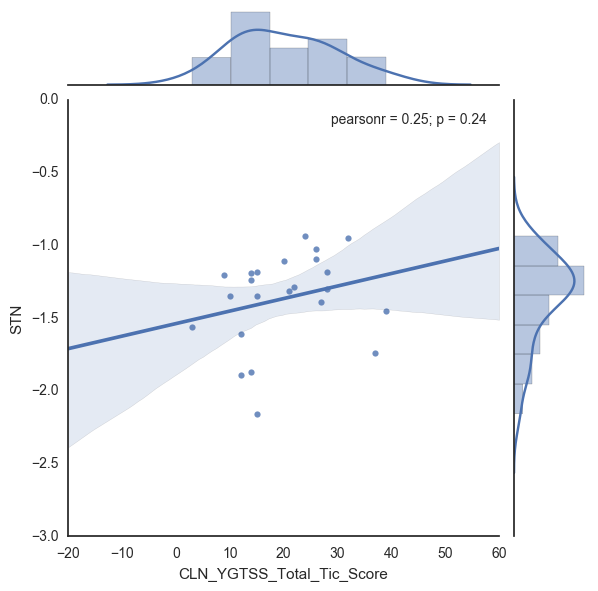

In [62]:
sns.jointplot(df['CLN_YGTSS_Total_Tic_Score'], np.log10(df['STN']), kind = 'reg')

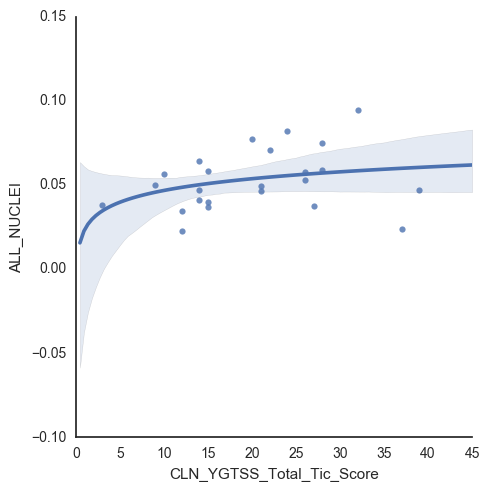

In [63]:
sns.lmplot('CLN_YGTSS_Total_Tic_Score', 'ALL_NUCLEI',df,  logx=1)

In [64]:
def get_polfit_r(X,y,d):
    coef = np.polyfit(X,y,d)
    results = {}
    results['polynomial'] = coef.tolist()
    p = np.poly1d(coef)
    yhat = p(X)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    ssreg / sstot
    results['determination'] = ssreg / sstot
    r = np.sqrt(results['determination'])
    N = len(VV.index)
    t = r/(np.sqrt((1-r**2) / (N-2)))
    p = ss.t.sf(t,df= (N-2) ) * 2
    return r, p


(0.40074200765007184, 0.064564002200250395)


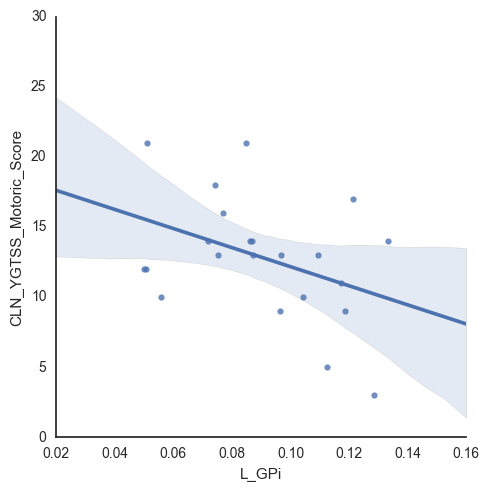

In [65]:
m1 = 'L_GPi'
m2 = 'CLN_YGTSS_Motoric_Score'
XX = patients_a.drop(['SA5U', 'DF2P'])
VV = pd.DataFrame([XX[m1],XX[m2] ]).T.dropna()

order= 1
print get_polfit_r(X = VV[m1], y = VV[m2], d=order)
sns.lmplot(x=m1, y=m2, data=VV,order=order, truncate= 0, ci = 95)
#plt.xlim(-0.01, 0.14)

In [190]:
m1 = 'CLN_YGTSS_Motoric_Score'
m2 = 'L_GPi'
x = df[m1].dropna()
y = df[m2]

In [191]:
dfx = pd.concat([x,y],axis = 1).dropna()
dfx[m1] = (dfx[m1] - np.mean(dfx[m1]) )/  np.std(dfx[m1])

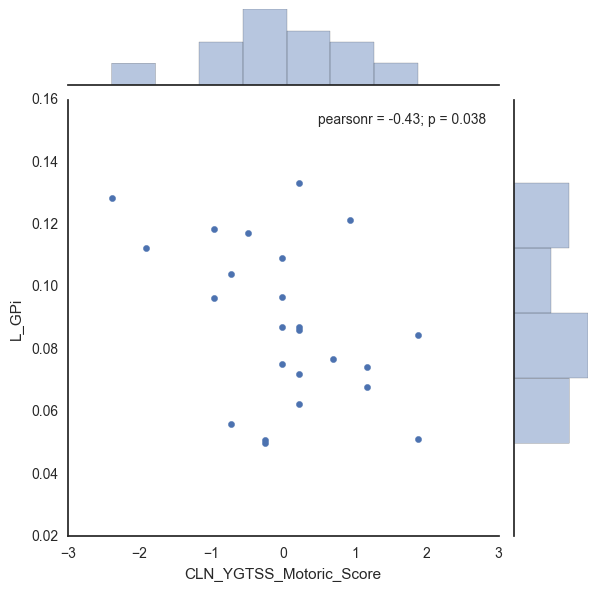

In [192]:
sns.jointplot(dfx[m1],dfx[m2])

In [167]:
preprocessing.scale(dfx['CLN_RVTRS'])

array([-0.63575443, -0.63575443, -0.63575443, -0.88385372, -0.88385372,
        1.59713918,  0.85284131, -0.88385372,  0.60474202,  0.85284131,
        0.10854344,  1.1009406 , -0.88385372, -0.63575443,  2.09333776,
       -1.13195301])

In [210]:
def return_correlation_tables(data, regressors, metabolites, clinical_measures):
    
    print 'Bonferroni threshold =',  0.05/ (len(clinical_measures) * len(metabolites) )
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    
    
    def make_multiple_reg(data, x, y):
        #print np.log((data[y] + 10))
        x_out = gESD_outliers(data, x)
        y_out = gESD_outliers(data, y)
        #print x, x_out 
        #print y, y_out
        df = pd.concat([df_reg, data[x].drop(x_out,axis=0), data[y].drop(y_out,axis=0) ], axis=1)
        df = df.dropna()
        df[x] = (df[x] - np.mean(df[x]) )/  np.std(df[x])
        
        formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
        model   = smf.ols(formula=formula, data= df)
        result = model.fit() 
        p_val  = np.round(result.pvalues[1], 3)
        pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
        
        if p_val < 0.05:
            print x, y, 'P_val=', p_val, 'R =', pcor
        return pcor, p_val
    
    stats_df = pd.DataFrame(index = clinical_measures,  columns=metabolites)   
    
    for clinical in clinical_measures:
        for metabolite in metabolites:
            p_cor, p_val = make_multiple_reg(data,  clinical, metabolite )
            #p_cor, p_val = spearmanr(data[clinical], data[metabolite])
            stats_df.loc['%s'%clinical][metabolite] = np.round(p_cor,3)
            stats_df.loc['%s'%clinical][metabolite] = np.round(p_val,3)
    return stats_df


In [216]:
clinical = ['CLN_RVTRS','CLN_YGTSS_Motoric_Score','CLN_YGTSS_Total_Score_incl_Impairment',
            'CLN_YGTSS_Total_Tic_Score','CLN_YGTSS_Vocal_Score',
            'CLN_puts','CLN_qol_score']

measures = ['Puta', 'Caud', 'Thal',
            'SN', 'STN', 'RN',  'GPi' , 'GPe',  
            #'DN','Hipp', 'Accu', 'Amyg', 
            #'STR_cMOT', 'STR_rMOT','AAN_PPN','AAN_VTA',
            'BrainStem','BasalGanglia', 'ALL_NUCLEI', 
           ]

measures = ['L_' + str(i) for i in measures]    
measures.append('CLN_Ferritin')
res = return_correlation_tables(patients_a, ['Age', 'Gender'], measures, clinical)
res

Bonferroni threshold = 0.000595238095238
CLN_YGTSS_Motoric_Score L_GPi P_val= 0.048 R = -0.437
CLN_qol_score L_STN P_val= 0.044 R = -0.426


,L_Puta,L_Caud,L_Thal,L_SN,L_STN,L_RN,L_GPi,L_GPe,L_BrainStem,L_BasalGanglia,L_ALL_NUCLEI,CLN_Ferritin
CLN_RVTRS,0.81,0.099,0.985,0.153,0.827,0.312,0.712,0.229,0.966,0.247,0.708,0.673
CLN_YGTSS_Motoric_Score,0.823,0.703,0.373,0.592,0.787,0.766,0.048,0.467,0.855,0.678,0.772,0.528
CLN_YGTSS_Total_Score_incl_Impairment,0.05,0.202,0.757,0.396,0.505,0.371,0.369,0.577,0.294,0.208,0.204,0.482
CLN_YGTSS_Total_Tic_Score,0.402,0.67,0.354,0.499,0.558,0.389,0.308,0.676,0.354,0.598,0.364,0.69
CLN_YGTSS_Vocal_Score,0.281,0.712,0.447,0.173,0.499,0.14,0.823,0.272,0.134,0.293,0.123,0.874
CLN_puts,0.684,0.802,0.969,0.79,0.218,0.693,0.876,0.28,0.362,0.616,0.376,0.918
CLN_qol_score,0.906,0.959,0.525,0.341,0.044,0.587,0.418,0.747,0.252,0.722,0.311,0.953


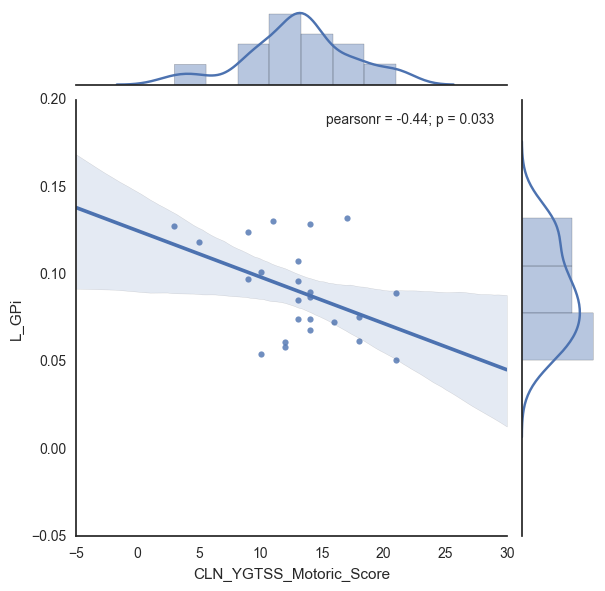

In [219]:
sns.jointplot('CLN_YGTSS_Motoric_Score', 'L_GPi', patients_a, kind = 'reg')

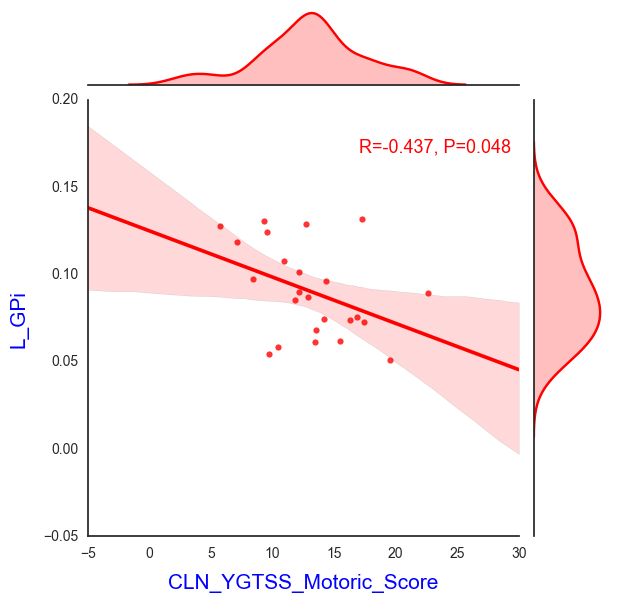

In [223]:
df = patients_a#pd.concat([patients_a, patients_b], axis=0)
x = 'CLN_YGTSS_Motoric_Score'
y = 'L_GPi'
#plot_joint(df,x,y, drop = [])
plot_partial_correlation(df, x, y, regressors = ['Age', 'Gender'], color = 'r', 
                         annotate = (17,0.17), fig_name = None, 
                         dpi = 100, labels = True, jitter = None,fit_reg=True, scatter=1, plot_marg = 1)